### First, we need to gather the data from imdb. You can use csv file provided in the repository or you can use the code below to scrape the data from imdb.

In [ ]:
from imdb_scraper.imdb_scraper import IMDBScraper
import pandas as pd
import datetime 
import glob
import os
import sqlite3
import ast
import matplotlib.pyplot as plt

db_name_path = 'imdb_top_movies.db'

### Scraping data from imdb yourself

In [ ]:
# first, we need to grab top 250 movies and their urls from imdb

imdb_scraper = IMDBScraper()
imdb_scraper.load_page('ipc-metadata-list-summary-item')
movies = imdb_scraper.scrape_top_movies_titles()

filename = f"movies_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
os.makedirs('csvs', exist_ok=True)
pd.DataFrame(movies).to_csv(os.path.join('csvs', filename), index=False)
print(f"Saved {len(movies)} movies to csvs/{filename}")

Page loaded successfully!
Saved 250 movies to movies_20250309_181605.csv


#### Then, we can scrape the details of each movie from a saved csv file

In [ ]:
paths = glob.glob('csvs/movies*.csv')

file_name = f'scraped_movies{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv'

if paths:

    movies = pd.read_csv(paths[0])
    scraper = IMDBScraper()

    existing_data = pd.DataFrame(columns=[
        'title',
        'release_date',
        'imdb_rating',
        'imdb_number_of_ratings',
        'popularity',
        'genres',
        'directors',
        'cast',
        'ranking',
        'url'
    ])

    errors = []

    rows_count = movies.shape[0]

    # we can grab ranking simply by counting the rows
    for ranking, (title, url) in enumerate(zip(movies['title'], movies['url']), start=1):
        print(f'{ranking}/{rows_count}) Scraping', title, '...')
        try:
            details = scraper.scrape_movie_details(url)

            details['ranking'] = ranking
            details['url'] = url

            existing_data = pd.concat([existing_data, pd.DataFrame([details])], ignore_index=True)
            print(title, 'successfully scraped!')

            existing_data.to_csv(f"movies_with_details_{file_name}", index=False)

        except Exception as e:
            print(f"Error scraping {title}: {e}")
            errors.append(
                {
                    'title': title,
                    'url': url,
                    'ranking': ranking
                }
            )

    if errors:  # retry for errors
        print('Errors:', errors, 'trying to scrape again...')
        for error in errors:
            print(f'{error['ranking']}/{len(errors)}) Scraping', error['title'], '...')

            try:
                details = scraper.scrape_movie_details(error['url'])

                details['ranking'] = error['ranking']
                details['url'] = error['url']

                existing_data = pd.concat([existing_data, pd.DataFrame([details])], ignore_index=True)
                print(error['title'], 'successfully scraped!')

                existing_data.to_csv(f"scraped_movies_with_details_{file_name}", index=False)

            except Exception as e:
                print(f"Error scraping {error['title']}: {e}")
else:
    print("No movies file found, please run scrape_save_top_movies.py first")

print(f"Scraping completed, saved to movies_with_details_{file_name}")

#### This will take a while, so you can use the provided csv file instead

### Now, we can transform the data. We can change ```imdb_number_of_ratings``` values to integer by turning 'M' into a million and 'K' into a thousand. Then we can change ```popularity``` values to int by removing commas.

In [ ]:
csv_files = glob.glob('csvs/scraped_movies_with_details_*.csv')

if not csv_files:
    print("No movies_with_details CSV files found")
else:
    # most recent file
    csv_path = max(csv_files, key=os.path.getctime)

    df = pd.read_csv(csv_path)

    df['imdb_number_of_ratings'] = df['imdb_number_of_ratings'].str.replace('M', 'e6').str.replace('K', 'e3').map(pd.eval).astype(int)    
    df['popularity'] = df['popularity'].apply(lambda x: int(x.replace(',', '')) if isinstance(x, str) else x)

    df.to_csv(csv_path, index=False)

    print(f"Transformed data saved to {csv_path}")


### Now, we can put the data into a database. First, lets create the database and the tables

In [5]:
def create_database(db_name="imdb_top_movies.db"):
    conn = sqlite3.connect(db_name)
    cursor = conn.cursor()
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS movies (
        movie_id INTEGER PRIMARY KEY,
        title TEXT NOT NULL,
        release_date TEXT,
        imdb_rating REAL,
        imdb_number_of_ratings TEXT,
        popularity REAL,
        ranking INTEGER,
        url TEXT
    )
    ''')

    cursor.execute('''
    CREATE TABLE IF NOT EXISTS persons (
        person_id INTEGER PRIMARY KEY,
        name TEXT UNIQUE NOT NULL
    )
    ''')

    cursor.execute('''
    CREATE TABLE IF NOT EXISTS genres (
        genre_id INTEGER PRIMARY KEY,
        name TEXT UNIQUE NOT NULL
    )
    ''')

    cursor.execute('''
    CREATE TABLE IF NOT EXISTS movie_genres (
        movie_id INTEGER,
        genre_id INTEGER,
        PRIMARY KEY (movie_id, genre_id),
        FOREIGN KEY (movie_id) REFERENCES movies (movie_id),
        FOREIGN KEY (genre_id) REFERENCES genres (genre_id)
    )
    ''')

    cursor.execute('''
    CREATE TABLE IF NOT EXISTS movie_directors (
        movie_id INTEGER,
        person_id INTEGER,
        PRIMARY KEY (movie_id, person_id),
        FOREIGN KEY (movie_id) REFERENCES movies (movie_id),
        FOREIGN KEY (person_id) REFERENCES persons (person_id)
    )
    ''')

    cursor.execute('''
    CREATE TABLE IF NOT EXISTS movie_cast (
        movie_id INTEGER,
        person_id INTEGER,
        PRIMARY KEY (movie_id, person_id),
        FOREIGN KEY (movie_id) REFERENCES movies (movie_id),
        FOREIGN KEY (person_id) REFERENCES persons (person_id)
    )
    ''')

    conn.commit()
    conn.close()

    print(f"Database {db_name} created successfully!")

create_database(db_name=db_name_path)

Database imdb_top_movies.db created successfully!


### Now, we can insert the data into the database

In [ ]:
def import_data_to_db(csv_path=None, db_name="imdb_movies.db"):
    if csv_path is None:
        csv_files = glob.glob('csvs/scraped_movies_with_details_*.csv')
        if not csv_files:
            print("No movies_with_details CSV files found")
            return
        # most recent file
        csv_path = max(csv_files, key=os.path.getctime)

    print(f"Importing data from: {csv_path}")

    df = pd.read_csv(csv_path)

    conn = sqlite3.connect(db_name)
    cursor = conn.cursor()

    for _, row in df.iterrows():
        cursor.execute('''
        INSERT INTO movies (title, release_date, imdb_rating, imdb_number_of_ratings, popularity, ranking, url)
        VALUES (?, ?, ?, ?, ?, ?, ?)
        ''', (
            row['title'],
            row['release_date'],
            float(row['imdb_rating']),
            row['imdb_number_of_ratings'],
            row['popularity'],
            row['ranking'],
            row['url']
        ))
        movie_id = cursor.lastrowid

        # genres
        try:
            genres = ast.literal_eval(row['genres']) if isinstance(row['genres'], str) else row['genres']
            for genre in genres:
                cursor.execute('INSERT OR IGNORE INTO genres (name) VALUES (?)', (genre,))
                cursor.execute('SELECT genre_id FROM genres WHERE name = ?', (genre,))
                genre_id = cursor.fetchone()[0]

                cursor.execute('INSERT INTO movie_genres (movie_id, genre_id) VALUES (?, ?)', (movie_id, genre_id))
        except (ValueError, SyntaxError):
            print(f"Error processing genres for {row['title']}")

        # directors
        try:
            directors = ast.literal_eval(row['directors']) if isinstance(row['directors'], str) else row['directors']
            for director in directors:
                cursor.execute('INSERT OR IGNORE INTO persons (name) VALUES (?)', (director,))
                cursor.execute('SELECT person_id FROM persons WHERE name = ?', (director,))
                person_id = cursor.fetchone()[0]

                cursor.execute('INSERT OR IGNORE INTO movie_directors (movie_id, person_id) VALUES (?, ?)', (movie_id, person_id))
        except (ValueError, SyntaxError):
            print(f"Error processing directors for {row['title']}")

        # cast
        try:
            cast = ast.literal_eval(row['cast']) if isinstance(row['cast'], str) else row['cast']
            for actor in cast:
                # Add actor if not exists
                cursor.execute('INSERT OR IGNORE INTO persons (name) VALUES (?)', (actor,))
                cursor.execute('SELECT person_id FROM persons WHERE name = ?', (actor,))
                person_id = cursor.fetchone()[0]

                cursor.execute('INSERT OR IGNORE INTO movie_cast (movie_id, person_id) VALUES (?, ?)', (movie_id, person_id))
        except (ValueError, SyntaxError):
            print(f"Error processing cast for {row['title']}")

    conn.commit()
    conn.close()
    print("Data import completed successfully")

import_data_to_db(db_name=db_name_path)

Importing data from: scraped_movies_with_details_20250303_202643.csv
Data import completed successfully


### Now, we can visualize some data

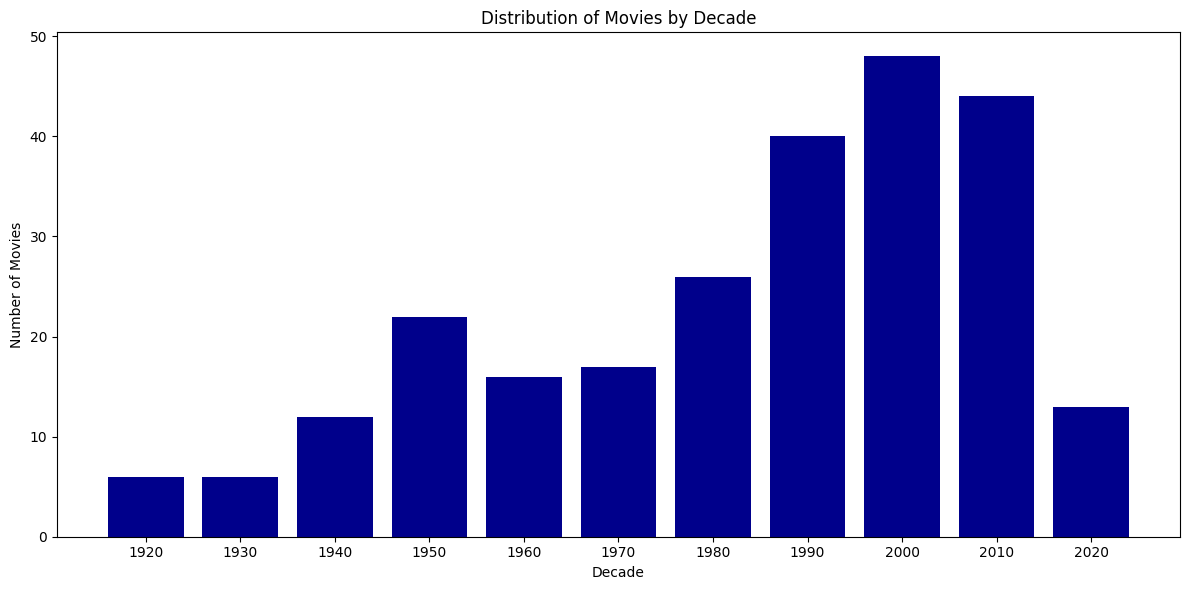

In [7]:
conn = sqlite3.connect(db_name_path)

query = """
SELECT release_date as year
FROM movies
"""

df = pd.read_sql_query(query, conn)
conn.close()

df['year'] = pd.to_numeric(df['year'])
df['decade'] = (df['year'] // 10) * 10
decade_counts = df['decade'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
plt.bar(decade_counts.index.astype(int), decade_counts.values, width=8, color='darkblue')
plt.xlabel('Decade')
plt.ylabel('Number of Movies')
plt.title('Distribution of Movies by Decade')
plt.xticks(decade_counts.index.astype(int))
plt.tight_layout()

plt.show()
plt.close()


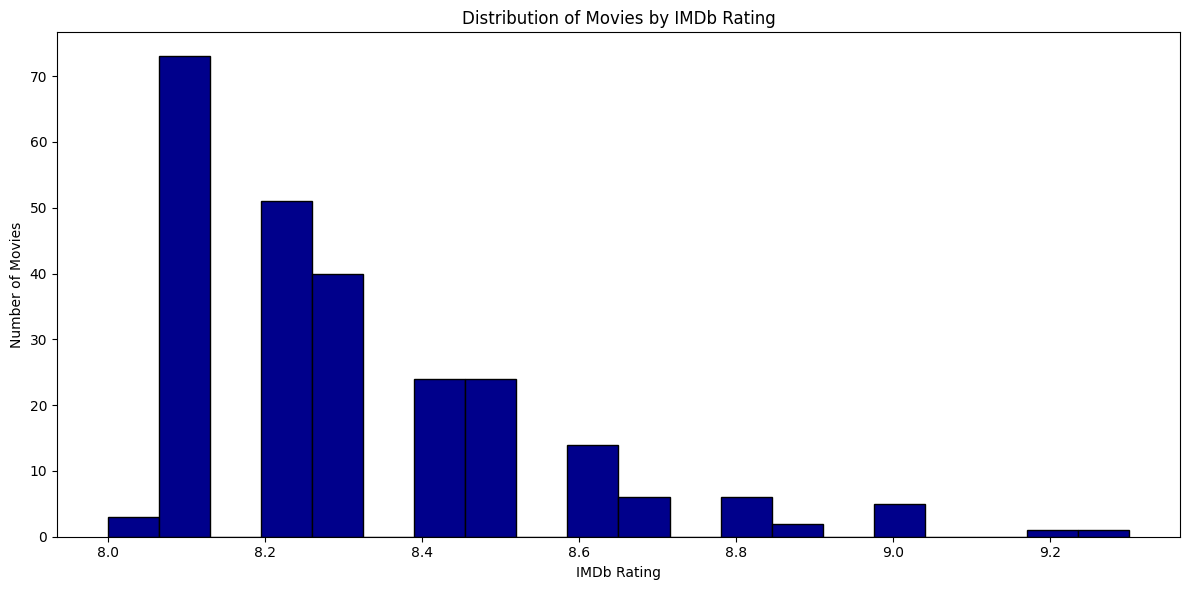

In [8]:
conn = sqlite3.connect(db_name_path)
    
query = """
SELECT imdb_rating
FROM movies
"""

df = pd.read_sql_query(query, conn)
conn.close()

plt.figure(figsize=(12, 6))
plt.hist(df['imdb_rating'], bins=20, color='darkblue', edgecolor='black')
plt.xlabel('IMDb Rating')
plt.ylabel('Number of Movies')
plt.title('Distribution of Movies by IMDb Rating')
plt.tight_layout()

plt.show()
plt.close()

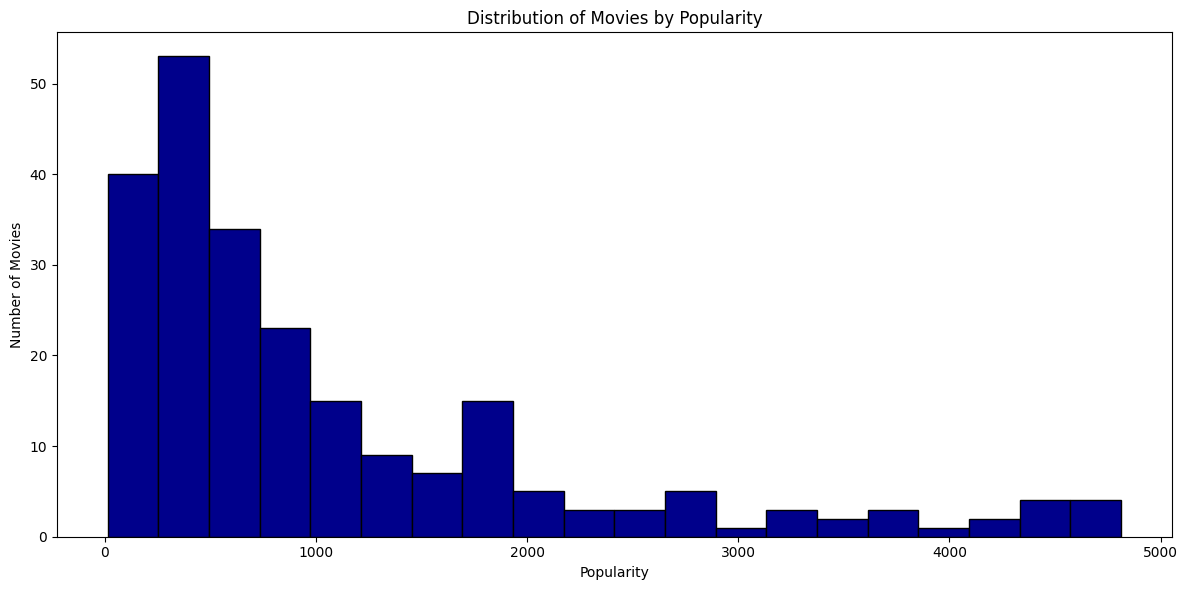

In [9]:
conn = sqlite3.connect(db_name_path)
    
query = """
SELECT popularity
FROM movies
WHERE popularity IS NOT NULL
"""

df = pd.read_sql_query(query, conn)
conn.close()

plt.figure(figsize=(12, 6))
plt.hist(df['popularity'], bins=20, color='darkblue', edgecolor='black')
plt.xlabel('Popularity')
plt.ylabel('Number of Movies')
plt.title('Distribution of Movies by Popularity')
plt.tight_layout()

plt.show()
plt.close()

<Figure size 1200x800 with 0 Axes>

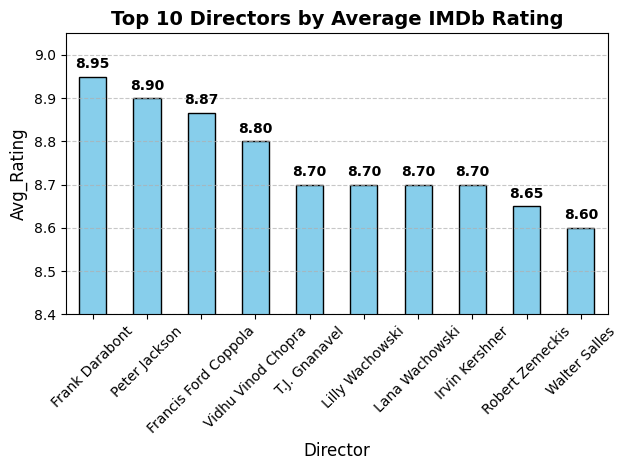

In [11]:
query = """
         SELECT p.name as Director,
         AVG(m.imdb_rating) as Avg_Rating 
         FROM persons p 
         JOIN movie_directors md 
         ON p.person_id = md.person_id 
         JOIN movies m 
         ON md.movie_id = m.movie_id 
         GROUP BY p.name 
         ORDER BY Avg_Rating DESC LIMIT 10
         """

conn = sqlite3.connect(db_name_path)
df = pd.read_sql_query(query, conn)
conn.close()

plt.figure(figsize=(12, 8))

ax = df.plot(kind='bar', x="Director", y="Avg_Rating", legend=False, color='skyblue', edgecolor='black')

y_min = max(0, df["Avg_Rating"].min() - 0.2)
y_max = min(10, df["Avg_Rating"].max() + 0.1) 
plt.ylim(y_min, y_max)

for i, v in enumerate(df["Avg_Rating"]):
    ax.text(i, v + 0.02, f'{v:.2f}', ha='center', fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.title("Top 10 Directors by Average IMDb Rating", fontsize=14, fontweight='bold')
plt.xlabel("Director", fontsize=12)
plt.ylabel("Avg_Rating", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()